In [1]:
import pandas as pd, matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("AAPL.csv")
def to_num(s):  # ép về số, bỏ dấu phẩy, $
    return pd.to_numeric(s.astype(str).str.replace(',','',regex=False).str.replace('$','',regex=False), errors='coerce')

for c in df.columns:
    if c.lower() not in ["date","time"]:
        df[c] = to_num(df[c])

# nếu không có cột Date, tạo index ngày làm việc cho đẹp
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce"); df = df.set_index("Date").sort_index()
else:
    import pandas as pd
    df.index = pd.bdate_range(start="2016-01-04", periods=len(df)); df.index.name = "Date"

price_col = "Adj Close" if "Adj Close" in df.columns else ("Price" if "Price" in df.columns else "Close")
df.head(), price_col


(            Price      Close       High        Low       Open       Volume
 Date                                                                      
 2016-01-04    NaN        NaN        NaN        NaN        NaN          NaN
 2016-01-05    NaN        NaN        NaN        NaN        NaN          NaN
 2016-01-06    NaN  24.261045  24.729268  23.821670  24.718172  212818400.0
 2016-01-07    NaN  23.577572  24.110148  23.391171  24.030261  257142000.0
 2016-01-08    NaN  23.579798  23.839428  23.218089  23.641931  263188400.0,
 'Price')

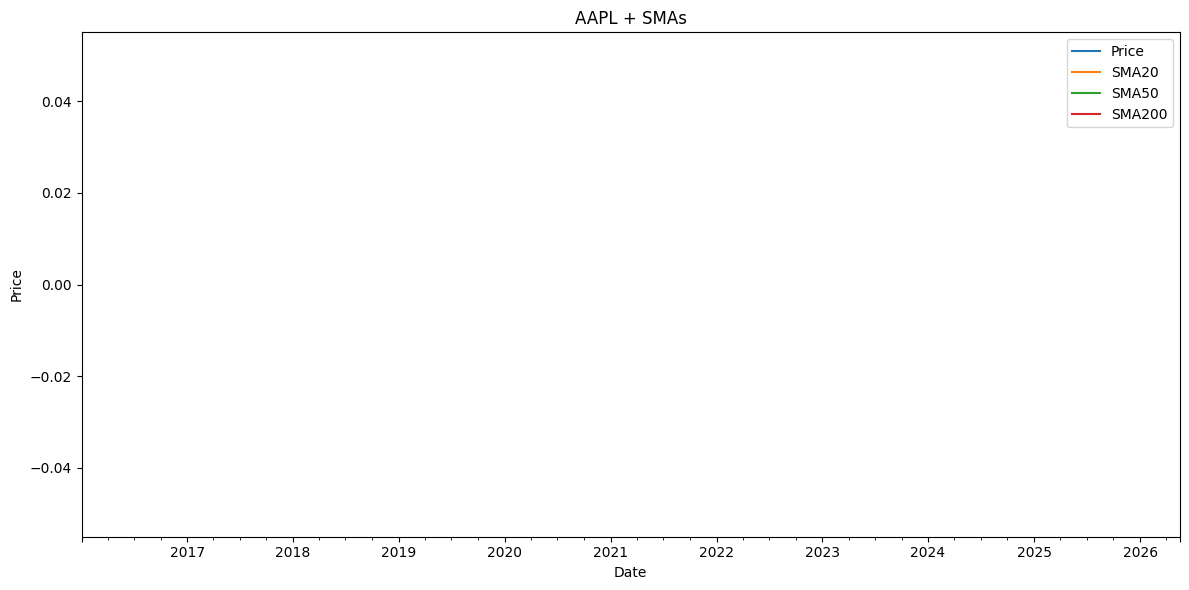

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# --- đảm bảo cột giá là số ---
price_col = "Adj Close" if "Adj Close" in df.columns else ("Price" if "Price" in df.columns else "Close")
df[price_col] = pd.to_numeric(df[price_col]
                              .astype(str)
                              .str.replace(',', '', regex=False)
                              .str.replace('$', '', regex=False),
                              errors='coerce')

# --- tính SMA với min_periods để tránh rỗng ---
for w in [20, 50, 200]:
    df[f"SMA{w}"] = df[price_col].rolling(window=w, min_periods=w).mean()

# --- chuẩn bị dữ liệu plot (ép float, bỏ NaN) ---
plot_df = df[[price_col, "SMA20", "SMA50", "SMA200"]].astype(float).dropna()

# fallback: nếu vẫn rỗng (dữ liệu ngắn) thì cho min_periods=1 để vẫn thấy đường
if plot_df.empty:
    for w in [20, 50, 200]:
        df[f"SMA{w}"] = df[price_col].rolling(window=w, min_periods=1).mean()
    plot_df = df[[price_col, "SMA20", "SMA50", "SMA200"]].astype(float)

# --- vẽ & lưu ---
ax = plot_df.plot(figsize=(12, 6), title="AAPL + SMAs")
ax.set_xlabel("Date"); ax.set_ylabel(price_col)
plt.tight_layout(); plt.savefig("aapl_sma.png", dpi=150); plt.show()


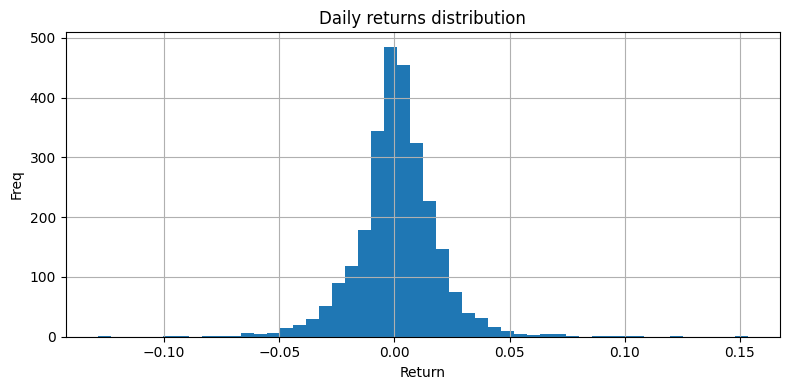

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# --- chọn cột giá có dữ liệu số ---
def to_num(s):
    return pd.to_numeric(
        s.astype(str).str.replace(',', '', regex=False).str.replace('$','', regex=False),
        errors='coerce'
    )

price_col = None
for c in ["Adj Close", "Close", "Price"]:   # ưu tiên Close trước Price vì Price của bạn đang rỗng
    if c in df.columns:
        s = to_num(df[c])
        if s.notna().sum() > 0:             # có số thật sự
            df[c] = s
            price_col = c
            break

if price_col is None:
    raise ValueError("Không tìm thấy cột giá dạng số (Adj Close / Close / Price).")

# --- Daily returns histogram ---
ret = df[price_col].pct_change(fill_method=None)  # tránh warning
ret = ret.dropna()

ax = ret.hist(bins=50, figsize=(8,4))
plt.title("Daily returns distribution"); plt.xlabel("Return"); plt.ylabel("Freq")
plt.tight_layout(); plt.savefig("aapl_returns_hist.png", dpi=150); plt.show()


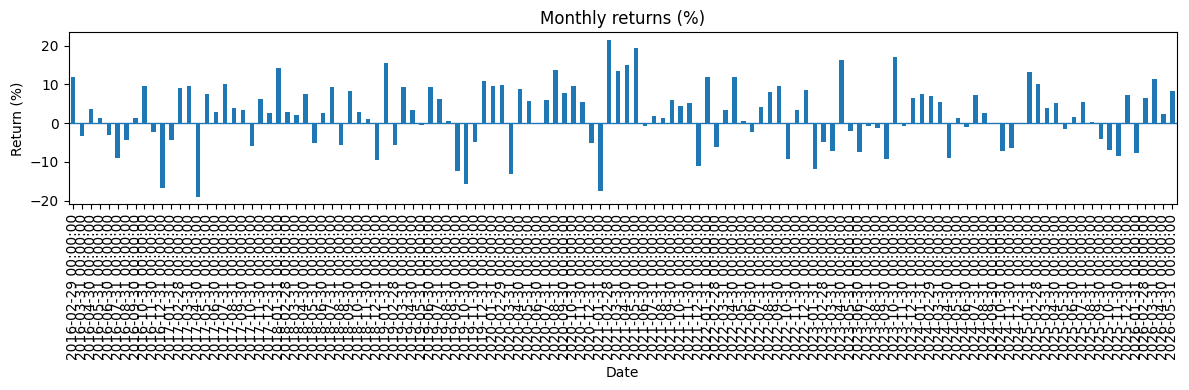

In [7]:
# Monthly returns bar (fix warning: use 'ME' instead of 'M')
monthly = (
    df[price_col]
    .resample("ME")                  # 'ME' = month-end, hoặc dùng "MS" nếu muốn month-start
    .last()
    .pct_change(fill_method=None)    # tránh FutureWarning khác
    .dropna()
)

ax = monthly.mul(100).plot(kind="bar", figsize=(12,4), title="Monthly returns (%)")
ax.set_ylabel("Return (%)")
ax.axhline(0, linewidth=1)           # đường 0% cho dễ nhìn
plt.tight_layout(); plt.savefig("aapl_monthly.png", dpi=150); plt.show()
